# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# Imported packages
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt 
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
from torch.autograd import Variable
import torchvision.transforms as transforms
import os
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

250
250
Number of faces detected: 1


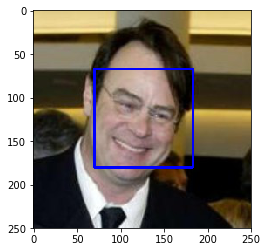

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# Get width and height of image
height, width = img.shape[:2]
print(height)
print(width)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
98 % of first 100 images in human_files have a detected human face.
17 % of first 100 images in dog_files have a detected human face.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
def getHumansDetected(file_list):
    humans = 0
    for file in file_list:
        if face_detector(file):
            humans += 1
    return humans

humans_in_human_files = getHumansDetected(human_files_short)
humans_in_dog_files = getHumansDetected(dog_files_short)

print((humans_in_human_files), "% of first 100 images in human_files have a detected human face.")
print((humans_in_dog_files), "% of first 100 images in dog_files have a detected human face.")

98 % of first 100 images in human_files have a detected human face.
17 % of first 100 images in dog_files have a detected human face.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
# Set model to evaluation mode
VGG16.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 98876312.19it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [8]:
from PIL import Image
from torch.autograd import Variable
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # load image 
    input_img = Image.open(img_path).convert('RGB')
    
    # Define transform
    input_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    # Apply transformation
    image = input_transform(input_img).unsqueeze(0)
    image = Variable(image)
    
    # Get predicted value
    if use_cuda:
        output = VGG16(image.cuda())
    else:
        output = VGG16(image)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Predicted class
    pred_index = int(pred.item())
    
    return pred # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted_index = VGG16_predict(img_path)
    is_dog = False
    if (151 <= predicted_index <= 268):
        is_dog = True
    return is_dog

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
2 % of the images in human_files_short have a detected dog.
97 % of the images in dog_files_short have a detected dog.

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def getDogsDetected(file_list):
    dogs = 0
    for file in file_list:
        if dog_detector(file):
            dogs += 1
    return dogs

humans_in_human_files = getDogsDetected(human_files_short)
humans_in_dog_files = getDogsDetected(dog_files_short)

print((humans_in_human_files), "% of the images in human_files_short have a detected dog.")
print((humans_in_dog_files), "% of the images in dog_files_short have a detected dog.")

2 % of the images in human_files_short have a detected dog.
97 % of the images in dog_files_short have a detected dog.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [11]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

# Define Inception-v3 model
incept3 = models.inception_v3(pretrained=True)

def inception_predict(img_path):
    # load image 
    input_img = Image.open(img_path).convert('RGB')
    
    # Define transform
    input_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    # Apply transformation
    image = input_transform(input_img).unsqueeze(0)
    image = Variable(image)
    
    # Get predicted value
    if use_cuda:
        output = incept3(image.cuda())
    else:
        output = incept3(image)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # Predicted class
    pred_index = int(pred.item())
    
    return pred # predicted class index

def dog_detector_incept3(img_path):
    ## TODO: Complete the function.
    predicted_index = VGG16_predict(img_path)
    is_dog = False
    if (151 <= inception_predict <= 268):
        is_dog = True
    return is_dog

def getDogsDetected_incept3(file_list):
    dogs = 0
    for file in file_list:
        if dog_detector(file):
            dogs += 1
    return dogs

humans_in_human_files = getDogsDetected_incept3(human_files_short)
humans_in_dog_files = getDogsDetected_incept3(dog_files_short)

print((humans_in_human_files), "% of the images in human_files_short have a detected dog.")
print((humans_in_dog_files), "% of the images in dog_files_short have a detected dog.")

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.torch/models/inception_v3_google-1a9a5a14.pth
100%|██████████| 108857766/108857766 [00:01<00:00, 99450770.18it/s]


1 % of the images in human_files_short have a detected dog.
100 % of the images in dog_files_short have a detected dog.


### Report on Inception V3
This model performed better than VGG16.

#### Results
1 % of the images in human_files_short have a detected dog.
100 % of the images in dog_files_short have a detected dog.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [12]:
import os
import torch
from torchvision import datasets, transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# define training, validation and test data directories
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# load and transform data using ImageFolder

# Define image transformers
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

train_data = datasets.ImageFolder(train_dir, transform=data_transform['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transform['test'])

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test':test_loader}

Num training images:  6680
Num validation images:  835
Num test images:  836


### Categories of dog breeds

In [13]:
# load list of dog names
dog_names = loaders_scratch['train'].dataset.classes
print("Dog breeds : ", len(dog_names))

Dog breeds :  133


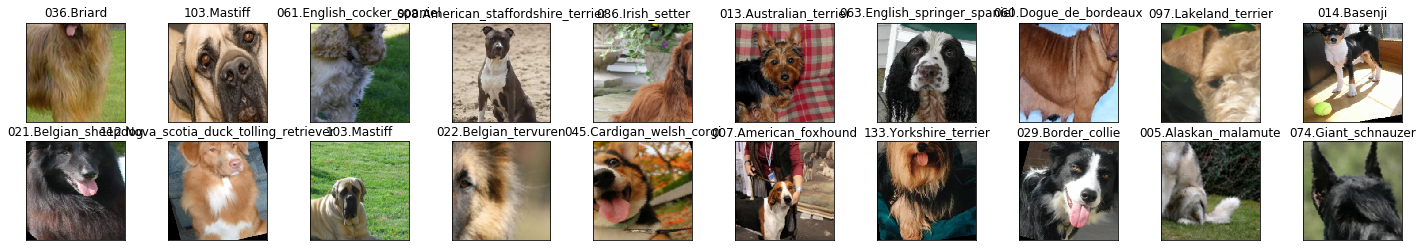

In [14]:
# View sample from dataset
import matplotlib.pyplot as plt                        
%matplotlib inline  

def tensor_to_image(tensor):
    tensor = tensor.numpy().squeeze()
    image = tensor.transpose(1,2,0)
    # revert transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_image(images[idx]))
    ax.set_title(dog_names[labels[idx]])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
1. Resized images to 256 and then to 224 by cropping at the center. Input tensor size is 224 because VGG-16 Takes 224x224 images as input, so we resize all of them
2. Augmentation was done to make sure dog face is identifiable in mirror image i.e horizontal flip and image was also rotated randomly by 45 degrees first but after many iterations settled on 15 degress, all this done randomly.

Also, to match the normalization used when the models were trained; each color channel was normalized separately, where the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
# Input image size is 224*224
# Each pooling layer half the size
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # convolutional layer (sees 28x28x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        # convolutional layer (sees 14x14x128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (256 * 7 * 7 -> 512)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        
        # linear layer (512 -> 133)
        self.fc2 = nn.Linear(512, 133)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

1. I began by trying previously used CNN architectures in this course like CIFAR 10 and the VGG16, which later was my base model as an inspiration
2. Input is 224 x 224 x 3 and Output is 133 classes
3. After several changes and iterations and learnings from various standard methodologies available, I stayed with the model defined above.
4. Convolutional steps were pretty simple and standard where I went with the multiple of computer memory 16,32,64 ending at 128 as I thought this is closest to 133 i.e. no of our classes.
5. With consecutive Max pooling Layers, I'm drying to downsample the size by a factor of 2 while increasing the depth by the same factor, input shape at each convolutional layer is defined in comments
6. I went wrong with the input shape for flattening image and had error in the first try; solved this using x.view before image flattening. Working on the math behind this output greatly enhanced my knowledge of CNN's and how the layer's work.
7. To avoid overfitting, I introduced drop out layer with 25% probability after each fully connected linear layer with ReLU activation.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [16]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses, valid_losses = [], []
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            ## record the average training loss, using something like
            #train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.item()*data.size(0)
                        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            #valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        
        train_losses.append(train_loss/len(train_loader))
        valid_losses.append(valid_loss/len(test_loader))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [18]:
# Fixes errors like 'OSError: image file is truncated (150 bytes not processed)'
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train the model
from workspace_utils import active_session
with active_session():
    model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.889687 	Validation Loss: 4.887089
Validation loss decreased (inf --> 4.887089).  Saving model ...
Epoch: 2 	Training Loss: 4.884607 	Validation Loss: 4.879191
Validation loss decreased (4.887089 --> 4.879191).  Saving model ...
Epoch: 3 	Training Loss: 4.875449 	Validation Loss: 4.867413
Validation loss decreased (4.879191 --> 4.867413).  Saving model ...
Epoch: 4 	Training Loss: 4.866343 	Validation Loss: 4.859398
Validation loss decreased (4.867413 --> 4.859398).  Saving model ...
Epoch: 5 	Training Loss: 4.859460 	Validation Loss: 4.847643
Validation loss decreased (4.859398 --> 4.847643).  Saving model ...
Epoch: 6 	Training Loss: 4.845963 	Validation Loss: 4.818054
Validation loss decreased (4.847643 --> 4.818054).  Saving model ...
Epoch: 7 	Training Loss: 4.806659 	Validation Loss: 4.742494
Validation loss decreased (4.818054 --> 4.742494).  Saving model ...
Epoch: 8 	Training Loss: 4.761320 	Validation Loss: 4.678143
Validation loss decreased (4.74249

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss += ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.603814


Test Accuracy: 16% (138/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [21]:
## TODO: Specify data loaders
import os
# define training, validation and test data directories
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# load and transform data using ImageFolder

# Define image transformers
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

train_data = datasets.ImageFolder(train_dir, transform=data_transform['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform['valid'])
test_data = datasets.ImageFolder(test_dir, transform=data_transform['test'])

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test':test_loader}

Num training images:  6680
Num validation images:  835
Num test images:  836


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [22]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
# resnet
model_transfer = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False

# get input features
n_inputs = model_transfer.fc.in_features    

# Define last layer
last_layer = nn.Linear(n_inputs, 133)

# add last layer
model_transfer.fc = last_layer

# check to see that your last layer produces the expected number of outputs
print(model_transfer.fc.out_features)

# if GPU is available, move the model to GPU
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 96862846.01it/s]


133


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
The dogs dataset uses 133 classes, and VGG16 is capable of identifying 118 dog breeds as seen earlier(268 - 151) with the dog detector exercise. Therefore, I shifted to ResNet50 which has less error rate than VGG16 and is also one of the recommended models. 

I avoided changing anything in the features and just made change in the last classification layer as it is a good model on the ImageNet and has hence already seen similar data, so no need to train the whole model for features again.

I obtained 71% accuracy with SGD optimizer and 25 epochs. Wanting to reduce the iterations for reaching low error rates, I tried used Adam optimizer and obtained x% accuracy with 20 epochs.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [23]:
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.001)
#optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [24]:
# Fixes errors like 'OSError: image file is truncated (150 bytes not processed)'
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train the model
n_epochs = 20
from workspace_utils import active_session
with active_session():
    model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.658683 	Validation Loss: 0.946953
Validation loss decreased (inf --> 0.946953).  Saving model ...
Epoch: 2 	Training Loss: 1.437864 	Validation Loss: 0.661171
Validation loss decreased (0.946953 --> 0.661171).  Saving model ...
Epoch: 3 	Training Loss: 1.241799 	Validation Loss: 0.630715
Validation loss decreased (0.661171 --> 0.630715).  Saving model ...
Epoch: 4 	Training Loss: 1.157181 	Validation Loss: 0.578941
Validation loss decreased (0.630715 --> 0.578941).  Saving model ...
Epoch: 5 	Training Loss: 1.083622 	Validation Loss: 0.562206
Validation loss decreased (0.578941 --> 0.562206).  Saving model ...
Epoch: 6 	Training Loss: 1.104820 	Validation Loss: 0.616031
Epoch: 7 	Training Loss: 1.023905 	Validation Loss: 0.656571
Epoch: 8 	Training Loss: 1.038085 	Validation Loss: 0.558620
Validation loss decreased (0.562206 --> 0.558620).  Saving model ...
Epoch: 9 	Training Loss: 0.999051 	Validation Loss: 0.586041
Epoch: 10 	Training Loss: 0.988696 	Valida

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [25]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.537042


Test Accuracy: 85% (712/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [26]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def image_to_tensor(img):
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    image_tensor = transform(img)
    return image_tensor.unsqueeze(0)

def predict_breed_transfer(img_path):
    # load the imag
    image_tensor = image_to_tensor(Image.open(img_path)) 
    if use_cuda:
        image_tensor = image_tensor.cuda()
    
    # Get the predicted breed
    output = model_transfer(image_tensor)
    
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    dog_breed = class_names[preds]
    return dog_breed

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [27]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def display_image(img_path, title="Title"):
    image = Image.open(img_path)
    plt.title(title)
    plt.imshow(image)
    plt.show()
    
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    # Check if detected dog
    if dog_detector(img_path):
        predicted_breed = predict_breed_transfer(img_path)
        print("Detected Dog.")
        print("You belong to the ", predicted_breed, " club!")
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
    elif face_detector(img_path):
        predicted_breed = predict_breed_transfer(img_path)
        print("Detected Human with dog face : ", predict_breed_transfer(img_path))
        print("You like like a ", predicted_breed, "!")
        display_image(img_path, title=f"Predicted:{predicted_breed}")
        
    else:
        print("This is neither a dog nor a human, maybe cat.")
        display_image(img_path, title="...")
        print("\n")


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The output is good, could be better.

1. The complete app in itself is very complicated and has too many unncessary cells, which could be moved to a python module for reuse.
2. The app could return top-N class probabilities and not just the final class.
3. The algorithm is trained and evaluated on images that are very close, if the dog appears far away it may fail to detect.
4. Thus better training images in more random poses could be used. Also images where dogs and humans are in the same picture could be used for training.
5. The code can be cleaned further to make it more clean and easy to execute and the app can be served as a Flask API, where we can take ensemble output from two or more different models to get the best result.

Detected Human with dog face :  Chihuahua
You like like a  Chihuahua !


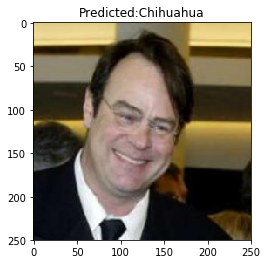

Detected Human with dog face :  American foxhound
You like like a  American foxhound !


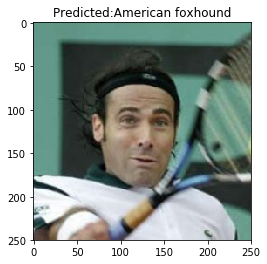

Detected Human with dog face :  American water spaniel
You like like a  American water spaniel !


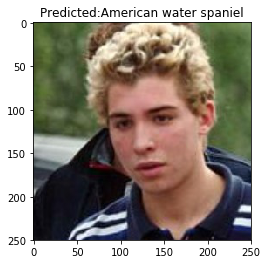

Detected Dog.
You belong to the  Bullmastiff  club!


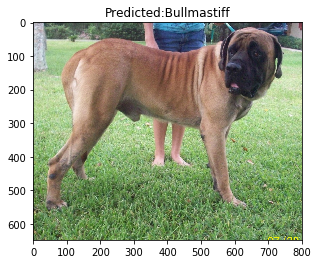

Detected Dog.
You belong to the  Bullmastiff  club!


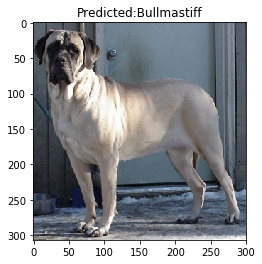

This is neither a dog nor a human, maybe cat.


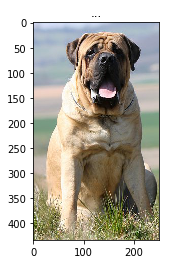

In [28]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

CustomImages/Dog_Human_3.jpg
This is neither a dog nor a human, maybe cat.


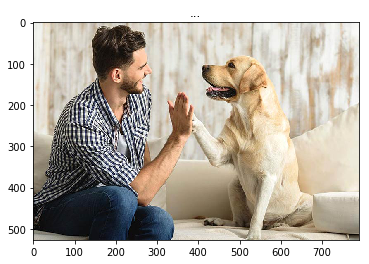



CustomImages/japanese_chinl.jpg
Detected Dog.
You belong to the  Papillon  club!


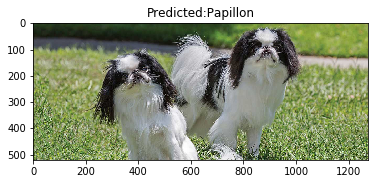

CustomImages/nova_scotia_retriever.jfif
Detected Dog.
You belong to the  Nova scotia duck tolling retriever  club!


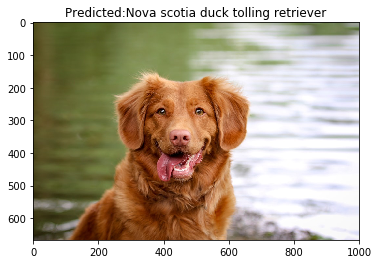

CustomImages/Dog_Human_2.jpg
This is neither a dog nor a human, maybe cat.


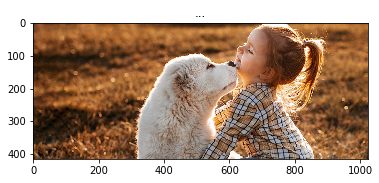



CustomImages/Dog_Human_1.jpg
Detected Dog.
You belong to the  Labrador retriever  club!


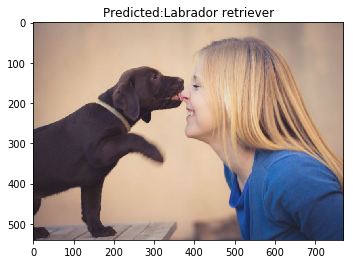

CustomImages/animated.png
This is neither a dog nor a human, maybe cat.


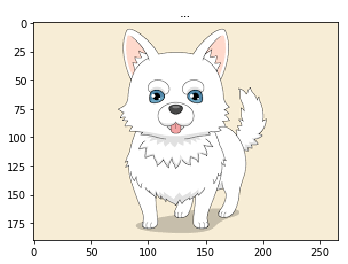

In [35]:
dog_dir = "CustomImages"
for item in os.listdir(dog_dir):
    sample = os.path.join(dog_dir, item)
    print(sample)
    run_app(sample)

## Verdict
The app seems unable to detect both humans and images in single image and is unable to detect two dogs also; although on a very small dataset. It is also not able to detect animated dog images.